# Final Project 
***
##### Group Members:  
Zhongyu Zhang - zz46xx  
Kevin Tan - st52xx  
Runze Li - rl50xx  
***

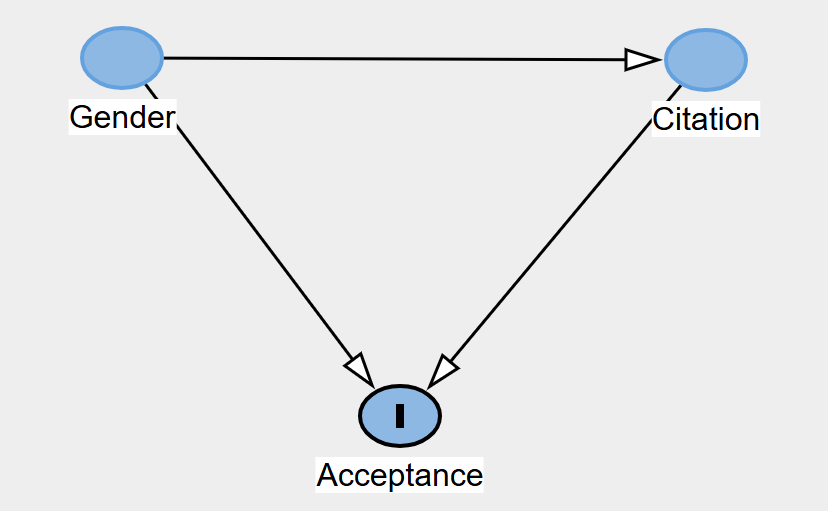

### Extract data we need from the database file _cs_conf_release.db_ 
SQL qurey code:  
```
SELECT de.forum AS submission_id, ausu.author_id, ag.reported_gender, agp.citedby, de.decision FROM decision de 
LEFT JOIN author_submission ausu ON de.forum=ausu.submission_id 
LEFT JOIN author_gender ag ON ausu.author_id=ag.author_id 
LEFT JOIN author_gscholar_profile agp ON ausu.author_id=agp.author_id;
```  
Notice that a paper could have difffernt authers, here we only consider the first auther.  
Saved as a csv file to _Data/ICLR-1.csv_  

In [9]:
import numpy as np
import pymc as pm
import arviz as az
from scipy import stats
import seaborn as sns
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import pytensor.tensor as pt

In [4]:
def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

### Read and process the csv file

In [10]:
iclr_df = pd.read_csv("Data/ICLR-1.csv", sep=",")

# The dataset dosen't have information on citation volume for some of the authors, so drop them
iclr_df = iclr_df.dropna(subset=["citedby"])  

# Transform the acceptance result from string to int 0~4
iclr_df["decision_new"] = pd.Categorical(
    iclr_df.decision.values,
    categories=[
        "Reject",
        "Invite to Workshop Track",
        "Accept (Poster)",
        "Accept (Spotlight)",
        "Accept (Oral)"
    ],
    ordered=True,
)
iclr_df["decision_new"] = iclr_df.decision_new.cat.codes

# Transform the authors' gender from string to int 0~3
iclr_df["gender_new"] = pd.Categorical(
    iclr_df.reported_gender.values,
    categories=[
        "Male",
        "Female",
        "Unspecified",
        "Non-Binary"
    ],
    ordered=True,
)
iclr_df["gender_new"] = iclr_df.gender_new.cat.codes

In [75]:
len(iclr_df)

7162

In [69]:
iclr_df['gender_new'].value_counts()

gender_new
0    5203
2    1408
1     543
3       8
Name: count, dtype: int64

### Check the distribution of authers' cited number

Text(0.5, 1.0, 'Original Cited Number Distribution')

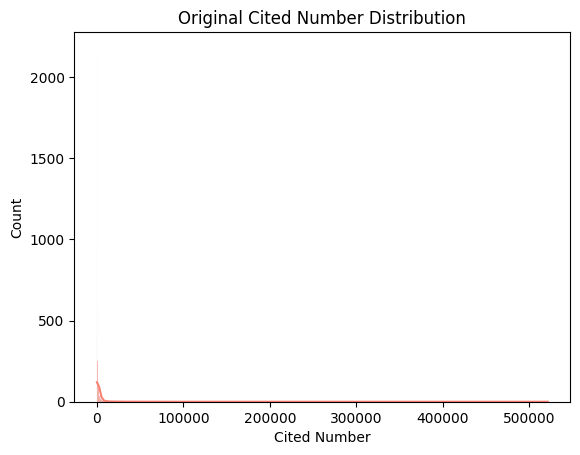

In [78]:
sns.histplot(iclr_df["citedby"].values, kde=True, color='salmon')
plt.xlabel("Cited Number")
plt.title("Original Cited Number Distribution")

Text(0.5, 1.0, 'Standardized Log Cited Number')

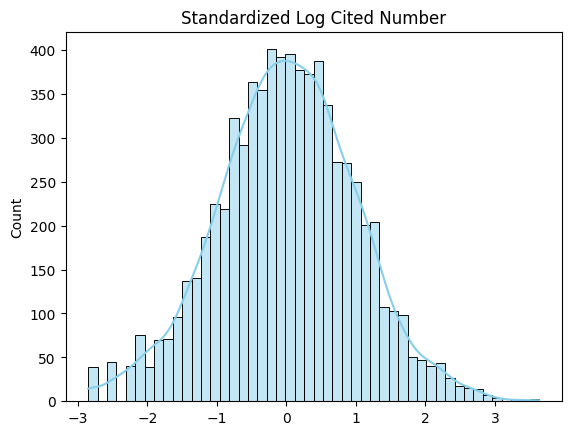

In [124]:
sns.histplot(standardize(np.log10(iclr_df["citedby"].values)), kde=True, color='skyblue')
plt.title("Standardized Log Cited Number")

In [11]:
iclr_df["decision_bin"] = iclr_df["decision_new"].values > 1

df2 = iclr_df.groupby("gender_new").agg(
    total=("gender_new", "count"),   
    accepted_count=("decision_bin", "sum") 
).reset_index()
print(df2)

   gender_new  total  accepted_count
0           0   5203            2077
1           1    543             204
2           2   1408             569
3           3      8               5


### Direct effect of gender on acceptance

In [84]:
N = df2.total
G = df2.gender_new  
A = df2.accepted_count

with pm.Model() as m_G_direct:
    b = pm.Normal("b", 0, 1, shape=len(np.unique(G)))
    p = pm.Deterministic("p", pm.math.invlogit(b[G]))
    mod_A = pm.Binomial("A", N, p, observed=A)
    
    idata_G_direct = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [85]:
az.summary(idata_G_direct, var_names=["b"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b[0],-0.409,0.029,-0.461,-0.353,0.000,0.000,6372.0,3334.0,1.0
b[1],-0.505,0.087,-0.668,-0.342,0.001,0.001,6304.0,2767.0,1.0
b[2],-0.387,0.054,-0.488,-0.286,0.001,0.000,8929.0,3325.0,1.0
b[3],0.359,0.605,-0.734,1.526,0.007,0.008,6698.0,3245.0,1.0


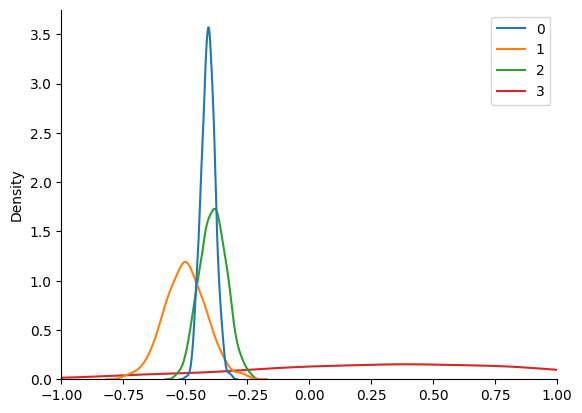

In [88]:
sns.kdeplot(idata_G_direct.posterior.b.values[0])
plt.xlim(-1, 1)
sns.despine();

#### Estimate with Counterfactual Simulation 

In [92]:
with pm.Model() as m_G_cf:
    # pm.Data allow for simulated interventions on variable
    d_G = pm.MutableData("gender", G.astype("int64"))
    d_N = pm.MutableData("number", N.astype("int64"))
    
    b = pm.Normal("b", 0, 1, shape=(len(np.unique(G))))
    p = pm.Deterministic("p", pm.math.invlogit(b[d_G]))
    mod_A = pm.Binomial("A", d_N, p, observed=A,  shape=d_G.shape[0])
    
    idata_G_cf = pm.sample()

total_apps = df2.total.sum()

with m_G_cf:
    # simulate as if all apps from men
    pm.set_data(
            {
                "number": np.repeat(1, total_apps),
                "gender": np.repeat(0, total_apps)
            }
    )

    cf_A_G0 = pm.sample_posterior_predictive(idata_G_cf)
    
with m_G_cf:
    # simulate as if all apps from women
    pm.set_data(
            {
                "number": np.repeat(1, total_apps),
                "gender": np.repeat(1, total_apps)
            }
    )

    cf_A_G1 = pm.sample_posterior_predictive(idata_G_cf)

# extract the posterior_predictive samples from the Inference Data object to simplify access and merge chains
accept_G0 = az.extract(cf_A_G0, group="posterior_predictive")
accept_G1 = az.extract(cf_A_G1, group="posterior_predictive")

# compute admit rate for each simulation by gender
num_samples = accept_G0.A.values.shape[1]
accept_rate_G0 = accept_G0.A.values.sum(1) / num_samples
accept_rate_G1 = accept_G1.A.values.sum(1) / num_samples

/home/zzypr/.local/lib/python3.10/site-packages/pymc/data.py:317: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
/home/zzypr/.local/lib/python3.10/site-packages/pymc/data.py:317: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [A]


Output()

Sampling: [A]


Output()

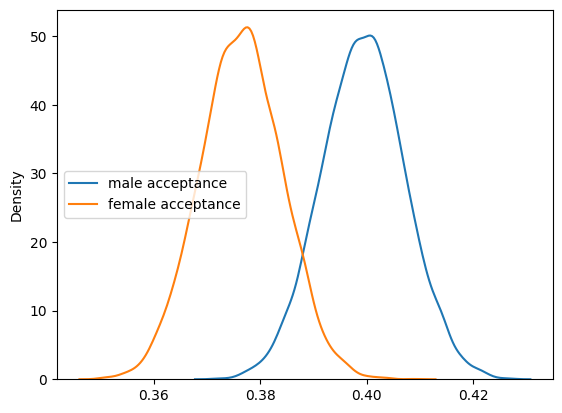

In [99]:
# plot the probalitly of acceptance for male and female
sns.kdeplot(accept_rate_G0, label="male acceptance")
sns.kdeplot(accept_rate_G1, label="female acceptance")
plt.legend()

### Total Effect of Gender and Cited Number 

#### Prior Simulation

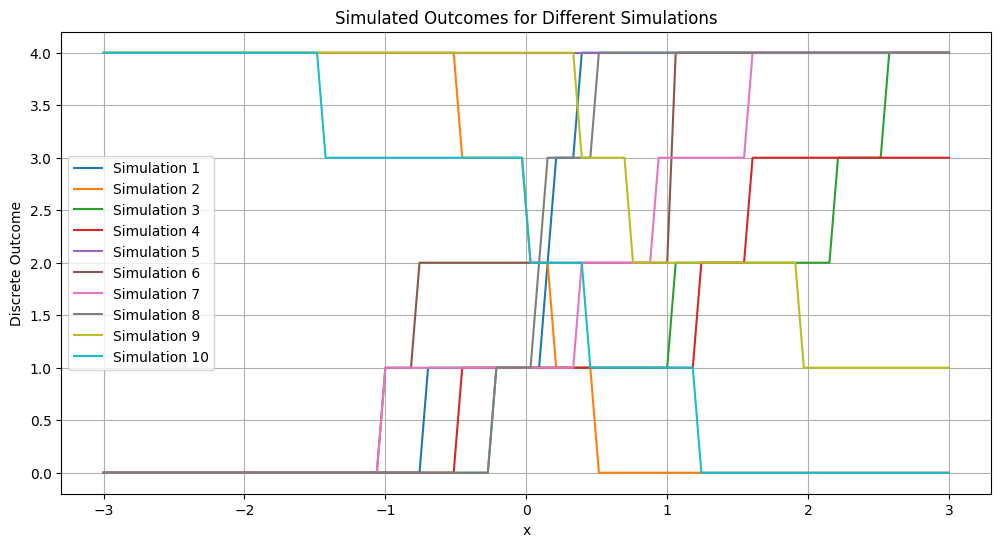

In [12]:
n_simulations = 20  
x = np.linspace(-3, 3, 100)    # cited number (loged and standardized)

simulated_outcomes = []

for _ in range(n_simulations):
    alpha = np.sort(stats.norm.rvs(loc=0, scale=1, size=4))
    b = stats.norm.rvs(loc=0, scale=1)
    phi = b * x
    outcome = np.digitize(phi, bins=alpha, right=True)
    simulated_outcomes.append(outcome)

simulated_outcomes = np.array(simulated_outcomes)


plt.figure(figsize=(12, 6))
for i in range(10):  
    plt.plot(x, simulated_outcomes[i], label=f"Simulation {i + 1}")
plt.title("Simulated Outcomes for Different Simulations")
plt.xlabel("x")
plt.ylabel("Discrete Outcome")
plt.legend()
plt.grid()
plt.show()

#### Model

In [13]:
G = iclr_df["gender_new"].values
A = iclr_df["decision_new"].values
C_log = standardize(np.log10(iclr_df["citedby"].values))

with pm.Model() as m_log:
    alpha = pm.Normal(
        "alpha",
        0.0,
        1,
        shape=4,
    )

    bC = pm.Normal("bC", 0.0, 1, shape=len(np.unique(G)))
    
    phi = bC[G] * C_log

    Acceptance = pm.OrderedLogistic("Acceptance", phi, cutpoints = alpha, observed=A)
    start = {'alpha': np.arange(4)}
    idata_log = pm.sample(start=start, idata_kwargs={"log_likelihood": True})
    ppc = pm.sample_posterior_predictive(idata_log)

/tmp/ipykernel_423/889938584.py:19: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  idata_log = pm.sample(start=start, idata_kwargs={"log_likelihood": True})
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, bC]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [Acceptance]


Output()

#### Posterior Predictive Check

<Axes: xlabel='Acceptance'>

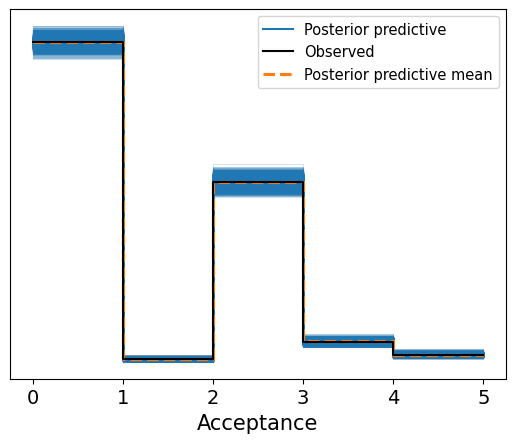

In [14]:
# Check the posterior predictive
az.plot_ppc(ppc, observed=True)

<Axes: xlabel='decision_new', ylabel='count'>

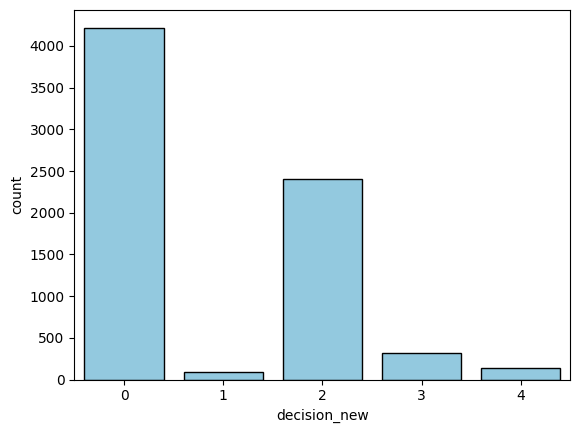

In [120]:
# distribution of the original outcome data
sns.countplot(data=iclr_df, x='decision_new', color='skyblue', edgecolor='black')

#### Analyze Coefficiency

In [15]:
az.summary(idata_log, var_names=["bC", "alpha"], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bC[0],0.22,0.03,0.16,0.27,0.00,0.00,3657.97,2527.89,1.0
bC[1],0.19,0.09,0.01,0.37,0.00,0.00,3521.64,2614.51,1.0
bC[2],0.14,0.05,0.04,0.23,0.00,0.00,3702.03,2947.19,1.0
bC[3],1.06,0.72,-0.32,2.35,0.01,0.01,3997.38,2626.92,1.0
alpha[0],0.36,0.02,0.32,0.41,0.00,0.00,1677.86,2185.28,1.0
alpha[1],0.42,0.02,0.37,0.46,0.00,0.00,1676.46,2250.66,1.0
alpha[2],2.70,0.05,2.60,2.78,0.00,0.00,2417.36,2528.19,1.0
alpha[3],3.91,0.09,3.74,4.07,0.00,0.00,2819.99,2718.25,1.0


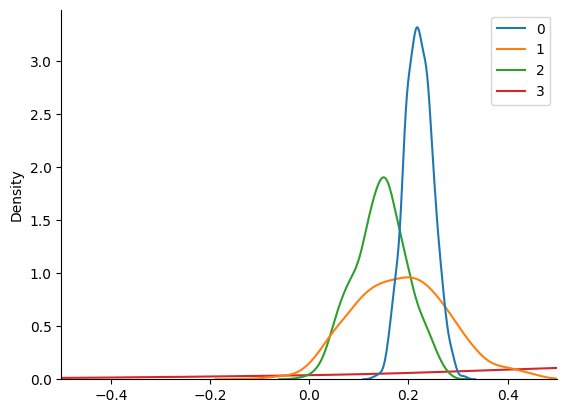

In [16]:
sns.kdeplot(idata_log.posterior.bC.values[0], color="#e06666")
plt.xlim(-0.5,0.5)
sns.despine();